In [2]:
from utils.modelUtils import load_sam, load_sam_inferer
#from classes.SAMClass import SAMWrapper, SAMInferer
from classes.SAMClass_new import SAMWrapper, SAMInferer

from utils.base_classes import Points
import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

# Obtain model, image, gt
device = 'cuda'
checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/sam_vit_h_4b8939.pth'

#sam_inferer = load_sam_inferer(checkpoint_path)

sam_model = load_sam(checkpoint_path)
sam_wrapper = SAMWrapper(sam_model, 'cuda')
sam_inferer = SAMInferer(sam_wrapper)

# Load in image, label, prompt
# img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
# img, gt = read_im_gt(img_path, gt_path)

img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 2)


In [10]:
import classes.SAMClass_new as c
import importlib
importlib.reload(c)
sam_inferer = c.SAMInferer(sam_wrapper)


In [41]:
# Experiment: 2d bounding box per slice with foreground
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)

segmentation = sam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 21/21 [00:00<00:00, 156.85it/s]


0.8690242677507083

In [14]:
# Experiment: n randomly sampled points from foreground
seed = 11121
n=5
pts_prompt = prUt.get_pos_clicks2D_row_major(gt, n, seed = seed)
segmentation = sam_inferer.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 21/21 [00:00<00:00, 39.64it/s]


0.11034912643757769

In [15]:
# Experiment: Given n equally spaced slices starting from the lowest axial slice with foreground to the highest, pick a 'central point' and interpolate a curve (DoF: linear vs cubic) between the points
n = 5
interpolation = 'linear'
simulated_clicks = prUt.get_fg_points_from_cc_centers(gt, n)
coords = prUt.interpolate_points(simulated_clicks, kind = interpolation).astype(int)
pts_prompt = Points({'coords': coords, 'labels': [1]*len(coords)})
segmentation = sam_inferer.predict(img, pts_prompt)

anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 21/21 [00:00<00:00, 139.73it/s]


0.05799243674780155

In [46]:
import numpy as np
from utils.promptUtils import get_bbox3d
def get_bbox3d_sliced(mask_volume: np.ndarray):
    bbox3d = get_bbox3d(gt)

    slices_to_infer = np.arange(bbox3d[0][0], bbox3d[1][0]) # gt is in ZYX format, so index 0 are the axial slices
    box_dict = {slice_idx: np.array((*bbox3d[0][1:], *bbox3d[1][1:])) for slice_idx in slices_to_infer}


{52: array([265, 417, 385, 530]),
 53: array([265, 417, 385, 530]),
 54: array([265, 417, 385, 530]),
 55: array([265, 417, 385, 530]),
 56: array([265, 417, 385, 530]),
 57: array([265, 417, 385, 530]),
 58: array([265, 417, 385, 530]),
 59: array([265, 417, 385, 530]),
 60: array([265, 417, 385, 530]),
 61: array([265, 417, 385, 530]),
 62: array([265, 417, 385, 530]),
 63: array([265, 417, 385, 530]),
 64: array([265, 417, 385, 530]),
 65: array([265, 417, 385, 530]),
 66: array([265, 417, 385, 530]),
 67: array([265, 417, 385, 530]),
 68: array([265, 417, 385, 530]),
 69: array([265, 417, 385, 530]),
 70: array([265, 417, 385, 530]),
 71: array([265, 417, 385, 530]),
 72: array([265, 417, 385, 530])}

In [53]:
# Experiment: get 3d bbox and slice it to feed it in 2d axially

box_prompt = prUt.get_bbox3d_sliced(gt)
segmentation = sam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 21/21 [00:00<00:00, 169.65it/s]


0.6693265425712777

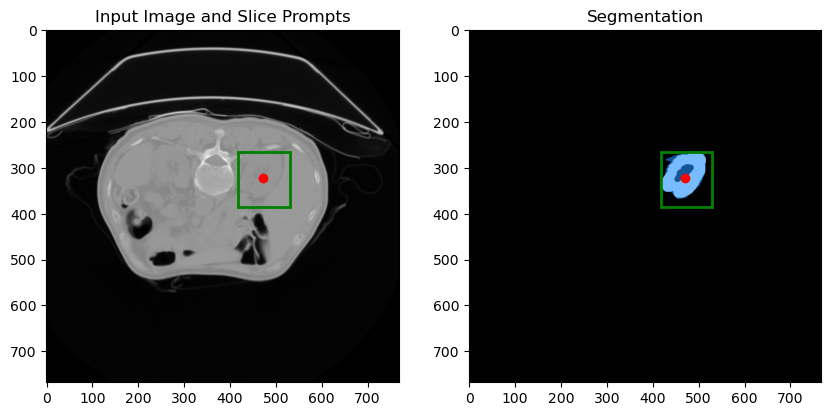

0.869031168432366

In [56]:
# Slice visualisation (points):
slice_idx = 66
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt= pts_prompt, box_prompt = box_prompt)

In [59]:
# Experiment: mask propagation: point
#def get_seed_point_and_bounds(gt):

slices_to_infer = np.where(np.any(gt, axis=(1,2)))[0] # index 0 since a tuple of length 1 is returned

In [69]:
def get_fg_point_from_slice(slice, n_clicks):
    slice_fg = np.where(slice)
    slice_fg = np.array(slice_fg).T

    n_fg_pixels = len(slice_fg)
    if n_fg_pixels >= n_clicks:
        point_indices = np.random.choice(n_fg_pixels, size = n_clicks, replace = False)
    else:
        # In this case, take all foreground pixels and then obtain some duplicate points by sampling with replacement additionally
        point_indices = np.concatenate([np.arange(n_fg_pixels),
                                    np.random.choice(n_fg_pixels, size = n_clicks-n_fg_pixels, replace = True)])
        
    pos_clicks_slice = slice_fg[point_indices]
    return(pos_clicks_slice)

array([[309, 475]])

Using previously generated image embeddings


Performing inference on slices: 100%|██████████| 1/1 [00:00<00:00, 120.12it/s]


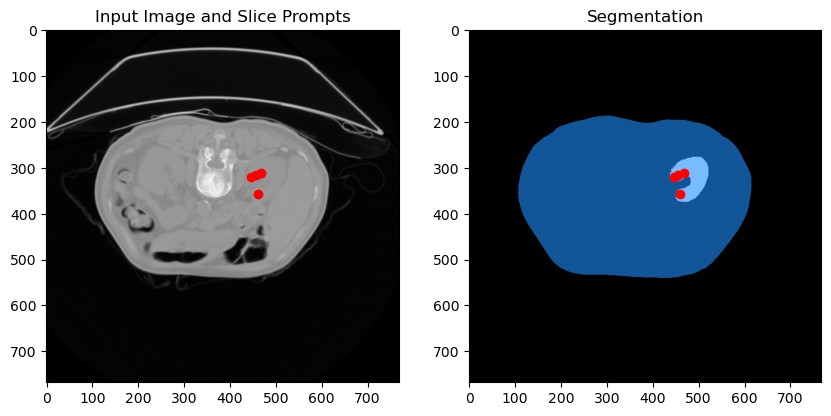

0.0708094473744554

In [97]:
n_clicks = 4

# Get seed prompt
middle_idx = np.median(slices_to_infer).astype(int)
slice = gt[middle_idx]
pos_clicks_slice = get_fg_point_from_slice(slice, n_clicks)

# Put coords in 3d contexta
z_col = np.full((n_clicks,1), middle_idx) # create z column to add
pos_coords = np.hstack([z_col, pos_clicks_slice])
pts_prompt = Points({'coords': pos_coords, 'labels': [1]*n_clicks})

segmentation = sam_inferer.predict(img, pts_prompt)
slice_idx = middle_idx
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt= pts_prompt)